1) Levantar los datos desde el archivo dataset/Telefonia_movil.csv.
Los mismos fueron extraídos de
http://datosabiertos.enacom.gob.ar/visualizations/29890/trafico-de
-suscriptores-de-telefonia-movil-miles-de-minutos/

2) Explorar los datos, visualizarlos

3) Implementar dos modelos (como ser Random Walk (Naïve) y
Exponential Smoothing)

4) Visualizar los resultados y evaluarlos, comparando ambas
implementaciones


## Practico 1 - Series Temporales

### Autor: Paez, Gaston 

In [4]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()
import statsmodels.api as sm
from IPython.display import display
from datetime import datetime

In [3]:
data=pd.read_csv("Telefonia_movil.csv").reset_index()
display(data.head(5), data.tail(5), data.dtypes)

,index,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
0,0,2013,1,8.785.943,6582117,15368060,Ene-Mar 2013
1,1,2013,2,9.512.689,7108640,16621329,Abr-Jun 2013
2,2,2013,3,10.315.484,7335154,17650638,Jul-Sept 2013
3,3,2013,4,9.809.515,6250549,16060064,Oct-Dic 2013
4,4,2014,1,10.128.751,5799223,15927974,Ene-Mar 2013


,index,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
20,20,2018,1,13.423.580,5850985,19274565,Ene-Mar 2018
21,21,2018,2,14.240.217,6027374,20267591,Abr-Jun 2018
22,22,2018,3,14.574.305,6108477,20682782,Jul-Sept 2018
23,23,2018,4,14.915.060,6613685,21528745,Oct-Dic 2018
24,24,2019,1,13.937.271,6427084,20364355,Ene-Mar 2019


index                                  int64
Año                                    int64
Trimestre                              int64
Minutos pospago salientes (miles)     object
Minutos prepago salientes (miles)      int64
Total de minutos salientes (miles)     int64
Periodo                               object
dtype: object

In [13]:
# Plot settings
sns.set_context('notebook') 
#sns.set_style('ticks')
sns.set()
%matplotlib inline

In [6]:
f=pd.period_range("2013Q1", "2019Q1", freq="Q" ) #Genero un arreglo de indices cuatrimestrales
trimestre= pd.DataFrame(data=f).reset_index()
display(trimestre.head(3))#Puedo hacer un merge de los dataframes o puedo reindexar
data_tri= pd.merge(trimestre,data, on="index" ,)
display(data_tri.head(3))

,index,0
0,0,2013Q1
1,1,2013Q2
2,2,2013Q3


,index,0,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
0,0,2013Q1,2013,1,8.785.943,6582117,15368060,Ene-Mar 2013
1,1,2013Q2,2013,2,9.512.689,7108640,16621329,Abr-Jun 2013
2,2,2013Q3,2013,3,10.315.484,7335154,17650638,Jul-Sept 2013


In [7]:
#Todavia no salve el problema con la columna pos_out que esta como objeto, tengo que pasarlo primero a categorico, sacarle los puntos y desp dejarlo en entero
data_tri.columns = ["index", "trimestre","año", "cuarto", "pos_out", "pre_out", "outs", "periodo"]
data_tri["pos_out"] = data_tri["pos_out"].astype("category").str.replace(".", "").astype("int") 

display(data_tri.dtypes, data_tri.tail(5))

index                int64
trimestre    period[Q-DEC]
año                  int64
cuarto               int64
pos_out              int32
pre_out              int64
outs                 int64
periodo             object
dtype: object

,index,trimestre,año,cuarto,pos_out,pre_out,outs,periodo
20,20,2018Q1,2018,1,13423580,5850985,19274565,Ene-Mar 2018
21,21,2018Q2,2018,2,14240217,6027374,20267591,Abr-Jun 2018
22,22,2018Q3,2018,3,14574305,6108477,20682782,Jul-Sept 2018
23,23,2018Q4,2018,4,14915060,6613685,21528745,Oct-Dic 2018
24,24,2019Q1,2019,1,13937271,6427084,20364355,Ene-Mar 2019


In [8]:
#Descripcion de las variables
data_tri.iloc[:,[4,5,6]].describe().round(2)

,pos_out,pre_out,outs
count,25.00,25.0,25.00
mean,12359295.44,6562909.4,18922204.72
std,2085582.33,516860.4,1982378.31
min,8785943.00,5380710.0,15368060.00
25%,10821463.00,6250549.0,17650638.00
50%,11905073.00,6579819.0,19001229.00
75%,14240217.00,7077838.0,20364355.00
max,15960765.00,7335154.0,22899656.00


Text(0.5, 1.0, 'Cantidad total de Minutos de telefonia movil')

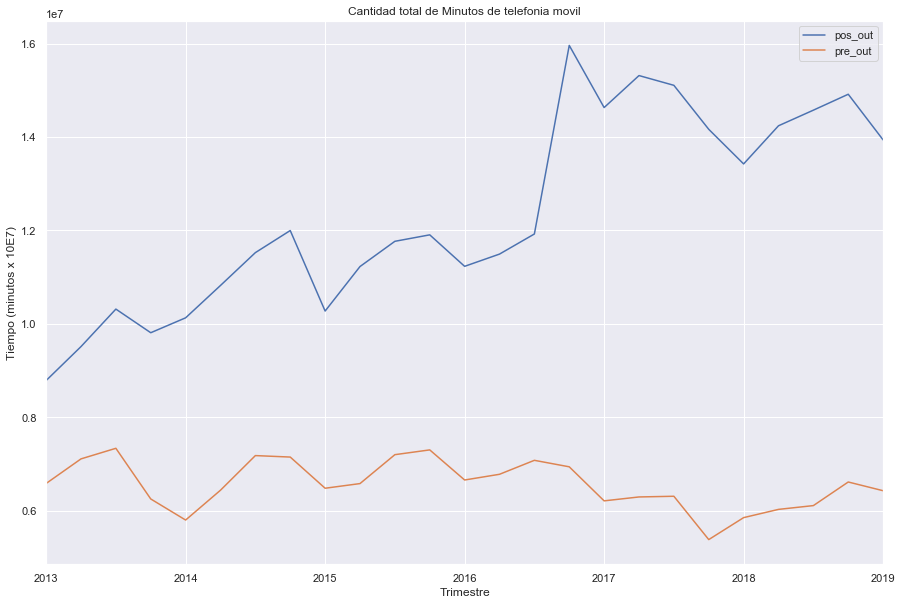

In [14]:
plt.rcParams['figure.figsize'] = [15, 10]
data_tri.plot( x= "trimestre", y= ["pos_out","pre_out"])
plt.xlabel("Trimestre")
plt.ylabel("Tiempo (minutos x 10E7)")
plt.title("Cantidad total de Minutos de telefonia movil")

In [15]:
data_lag=data_tri.iloc[:,[4,5,6]]
data_lag.head(3)

,pos_out,pre_out,outs
0,8785943,6582117,15368060
1,9512689,7108640,16621329
2,10315484,7335154,17650638


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


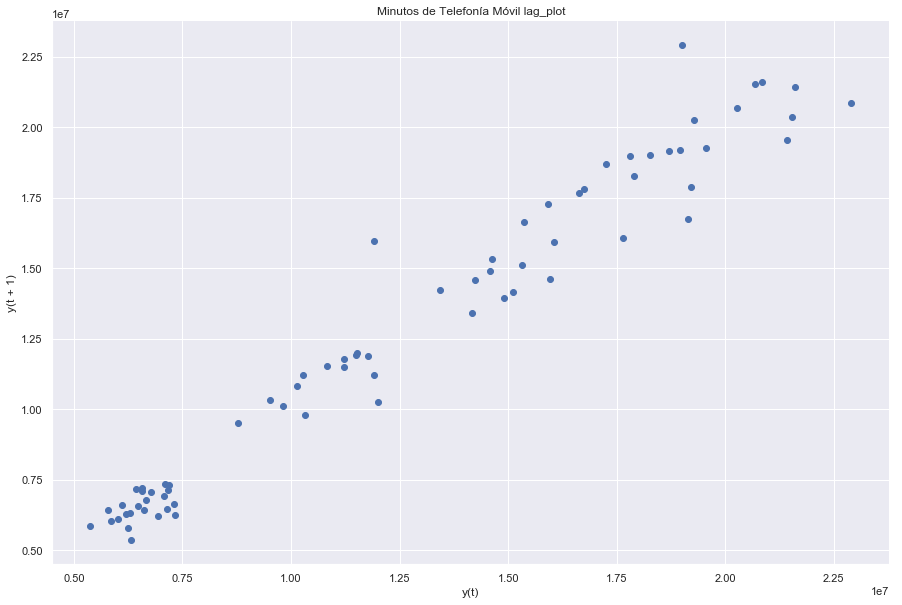

In [16]:
from pandas.plotting import lag_plot
ax = lag_plot(data_lag, lag=1)
ax.set_title('Minutos de Telefonía Móvil lag_plot')
sns.despine()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

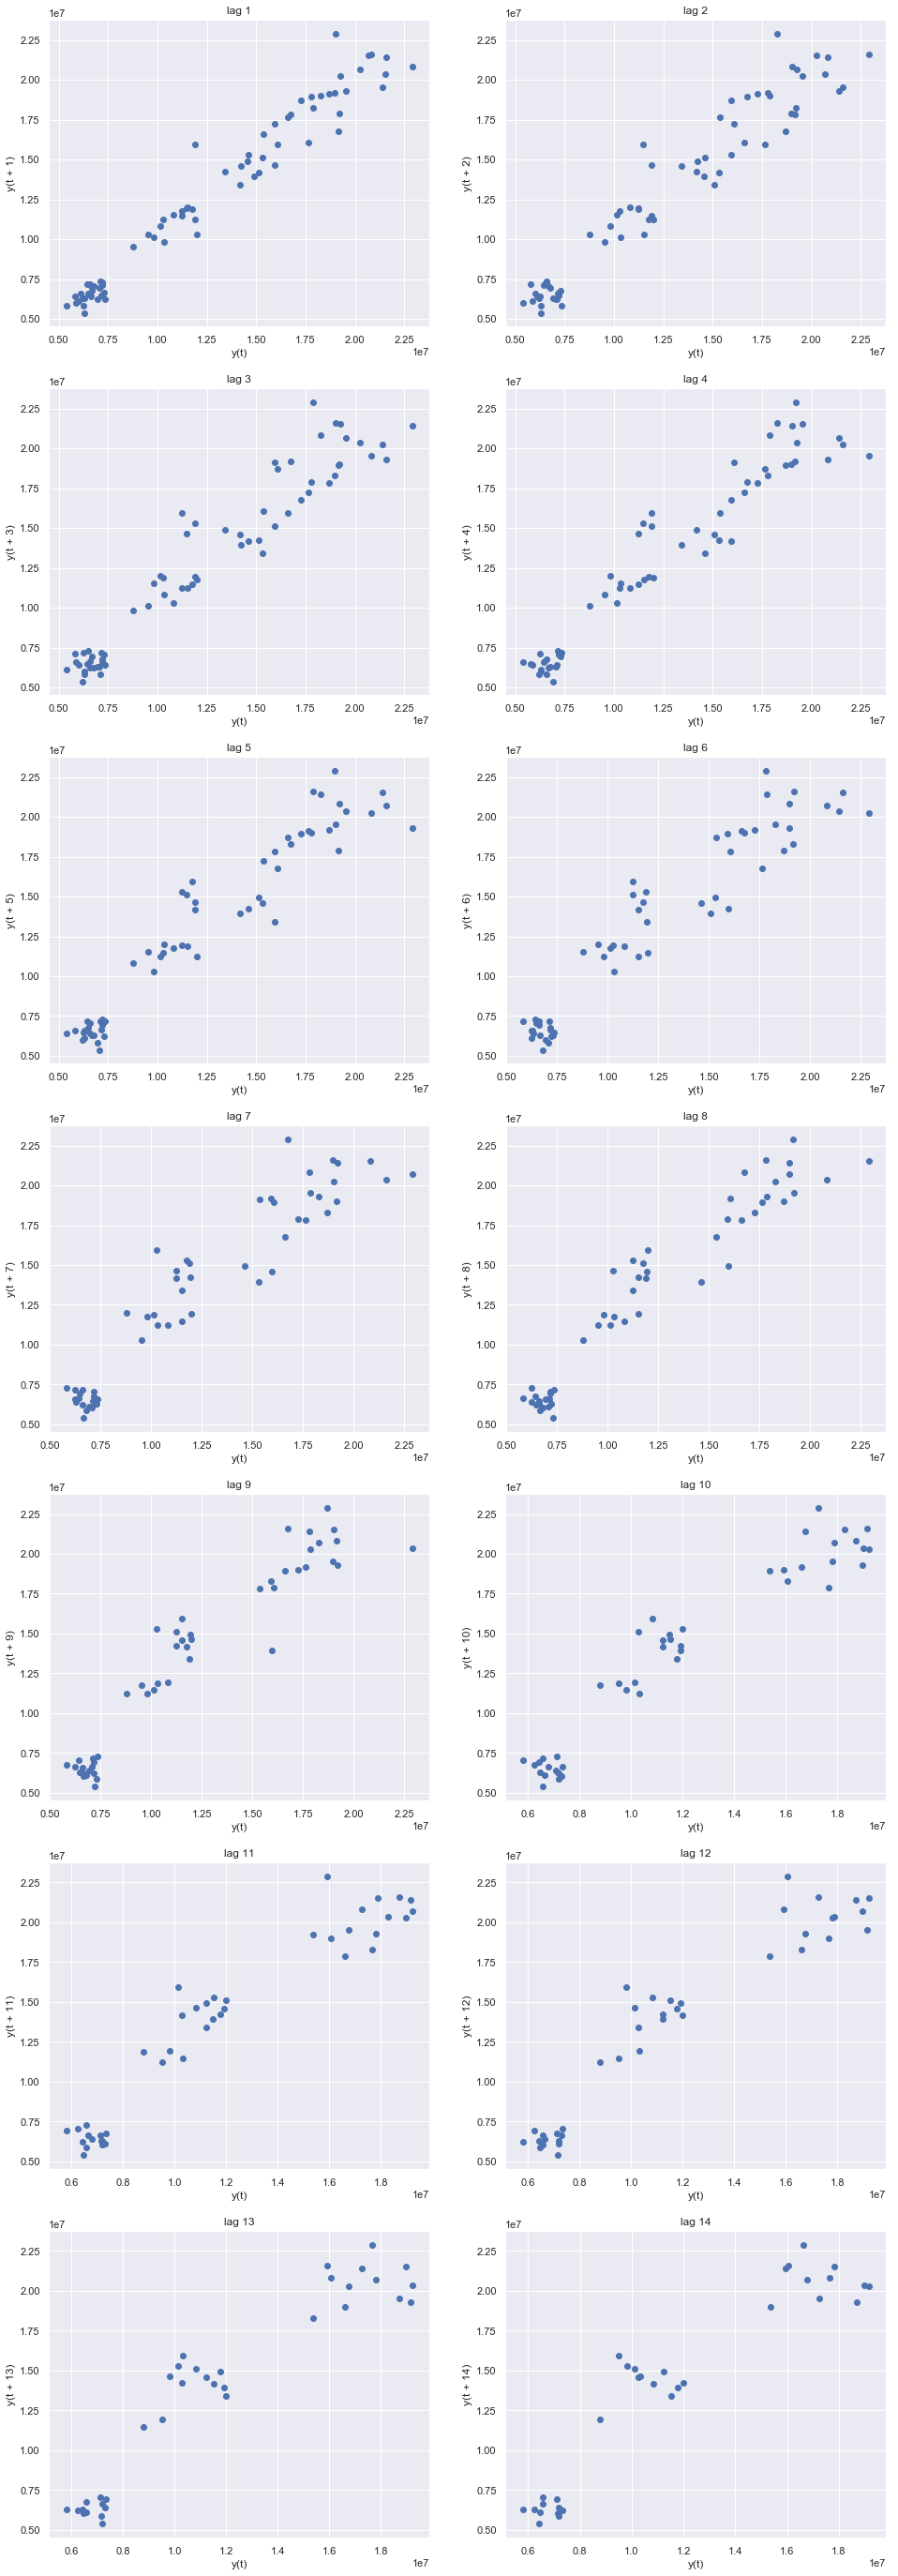

In [18]:
#Buscamos ver estacionalidad 
plt.rcParams['figure.figsize'] = [16, 100]
for i in range(14):
    plt.subplot(14,2,i+1)
    plt.title("lag " + str(i+1))
    lag_plot(data_lag, lag=i+1);


### Observacion: No se observa fenomeno estacional

# RANDOM WALK

In [22]:
y=data_tri.set_index("trimestre")
y.head()

,index,año,cuarto,pos_out,pre_out,outs,periodo
trimestre,,,,,,,
2013Q1,0,2013,1,8785943,6582117,15368060,Ene-Mar 2013
2013Q2,1,2013,2,9512689,7108640,16621329,Abr-Jun 2013
2013Q3,2,2013,3,10315484,7335154,17650638,Jul-Sept 2013
2013Q4,3,2013,4,9809515,6250549,16060064,Oct-Dic 2013
2014Q1,4,2014,1,10128751,5799223,15927974,Ene-Mar 2013


In [23]:
y_pos= y["pos_out"]
y_pre=y["pre_out"]


In [24]:
y_pre.index

PeriodIndex(['2013Q1', '2013Q2', '2013Q3', '2013Q4', '2014Q1', '2014Q2',
             '2014Q3', '2014Q4', '2015Q1', '2015Q2', '2015Q3', '2015Q4',
             '2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1', '2017Q2',
             '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4',
             '2019Q1'],
            dtype='period[Q-DEC]', name='trimestre', freq='Q-DEC')

## Postpago


In [25]:
# Modelo:
h = 4
test_pos=pd.period_range(start=y_pos.index[-1]+1, periods=h, freq='Q')
pred_pos=pd.Series(np.repeat(y_pos.iloc[-1], h), index=test_pos) # the forecast repeats the last observed values h times
display(pred_pos, y_pos.tail(5) )

2019Q2    13937271
2019Q3    13937271
2019Q4    13937271
2020Q1    13937271
Freq: Q-DEC, dtype: int32

trimestre
2018Q1    13423580
2018Q2    14240217
2018Q3    14574305
2018Q4    14915060
2019Q1    13937271
Freq: Q-DEC, Name: pos_out, dtype: int32

In [26]:
resid_pos=y_pos - y_pos.shift(1) # the shift lags the series by one period
sigma = resid_pos.std()
round(sigma,3)

1111026.926

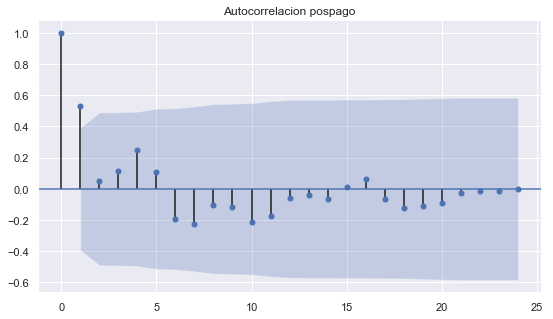

In [27]:
fig, ax = plt.subplots(); 
sm.graphics.tsa.plot_acf(data_lag.iloc[:,1], lags=24, ax=ax) #Debemos ajustar a la cantidad de lags correspondientes
sns.despine()
plt.title("Autocorrelacion pospago")
plt.show()

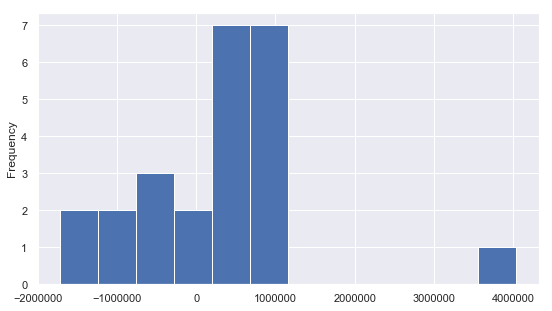

In [28]:
plt.rcParams['figure.figsize'] = [9, 5]
resid_pos.plot.hist(bins=12);

In [29]:
np.arange(1,h+1)

array([1, 2, 3, 4])

In [30]:
# Prediccion de intervalos; cotas
print("Prediccion (postpago)")
intv_pos = pd.concat([pred_pos - stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred_pos +stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv_pos.round(1)

Prediccion (postpago)


,0,1
2019Q2,11759698.2,16114843.8
2019Q3,10857718.1,17016823.9
2019Q4,10165604.3,17708937.7
2020Q1,9582125.5,18292416.5


## - Prepago

In [31]:
test_pre=pd.period_range(start=y_pre.index[-1]+1, periods=h, freq='Q')
pred_pre=pd.Series(np.repeat(y_pre.iloc[-1], h), index=test_pre) # the forecast repeats the last observed values h times
pred_pre

2019Q2    6427084
2019Q3    6427084
2019Q4    6427084
2020Q1    6427084
Freq: Q-DEC, dtype: int64

In [32]:
resid_pre = y_pre - y_pre.shift(1) # the shift lags the series by one period
sigma = resid_pre.std()
round(sigma,3)

510832.977

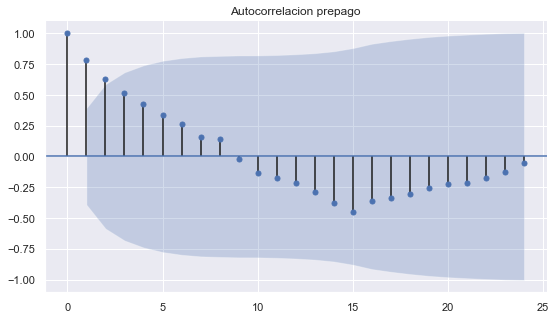

In [33]:
fig, ax = plt.subplots(); #figsize=(52,35)
sm.graphics.tsa.plot_acf(data_lag.iloc[:,0], lags=24, ax=ax) #Debemos ajustar a la cantidad de lags correspondientes
sns.despine()
plt.title("Autocorrelacion prepago")
plt.show()

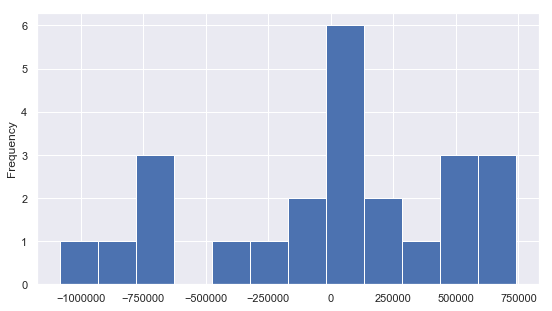

In [34]:
resid_pre.plot.hist(bins=12);

In [35]:
#Prediccion (prepago)
print("Prediccion (prepago)")
intv_pre = pd.concat([pred_pre - stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred_pre +stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv_pre.round(1)

Prediccion (prepago)


,0,1
2019Q2,5425869.8,7428298.2
2019Q3,5011153.2,7843014.8
2019Q4,4692930.1,8161237.9
2020Q1,4424655.5,8429512.5


## - Gráficos de intervalo de confianza

In [36]:
""" Plotting methods for temp series """

__author__ = "Marcel Scharth"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_components_x13(results, label=''):
    colours=['#D62728', '#FF7F0E', '#2CA02C', '#1F77B4']
    fig, ax = plt.subplots(2,2, figsize=(12,8))
    ax[0,0].plot(results.observed, color=colours[0], alpha=0.95)
    ax[0,0].set(ylabel=label, title='Observed')
    ax[0,1].plot(results.trend, color=colours[1], alpha=0.95)
    ax[0,1].set(title='Trend')
    ax[1,0].plot(results.observed/results.seasadj, color=colours[2],  alpha=0.95)
    ax[1,0].set(ylabel=label, title='Seasonal')
    ax[1,1].plot(results.irregular, color=colours[3],  alpha=0.95)
    ax[1,1].set(title='Irregular')
    sns.despine()
    fig.suptitle('Time series decomposition  (X-13 ARIMA-SEATS)', fontsize=13.5)   
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    return fig, ax

def fanchart(y, forecast, intv1, intv2, intv3,color):
    assert type(y)==pd.core.series.Series, 'The time series must be a pandas series'
    assert type(forecast)==pd.core.series.Series, 'The forecast must be a pandas series'

    last=y.iloc[-1:]
    extended=last.append(forecast)

    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(figsize=(8,5))
        y.plot(color=color,marker='o',alpha=0.7)
        extended.plot(color='black', alpha=0.4, label='Point forecast')
        ax.fill_between(extended.index, last.append(intv3.iloc[:,0]), last.append(intv3.iloc[:,1]),
                        facecolor=color, lw=0, alpha=0.3)
        ax.fill_between(extended.index, last.append(intv2.iloc[:,0]), last.append(intv2.iloc[:,1]),
                        facecolor=color, lw=0, alpha=0.3)
        ax.fill_between(extended.index, last.append(intv1.iloc[:,0]), last.append(intv1.iloc[:,1]),
                        facecolor=color, lw=0, alpha=0.3)
        hold = ax.get_ylim()
        ax.fill_betweenx(ax.get_ylim(), extended.index[0], extended.index[-1], facecolor='grey', alpha=0.15)
        ax.set_ylim(hold)
    return fig, ax

def histogram(series):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': '#1F77B4'},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

def qq_plot(residuals):
    fig, ax = plt.subplots(figsize=(8,5))
    pp = sm.ProbPlot(residuals, fit=True)
    qq = pp.qqplot(color='#1F77B4', alpha=0.8, ax=ax)
    a=ax.get_xlim()[0]
    b=ax.get_xlim()[1]
    ax.plot([a,b],[a,b], color='black', alpha=0.6)
    ax.set_xlim(a,b)
    ax.set_title('Normal Q-Q plot for the residuals', fontsize=12)
    return fig, ax

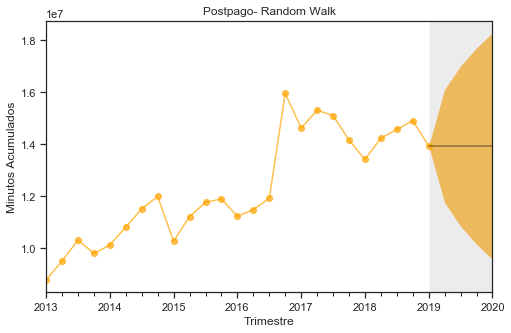

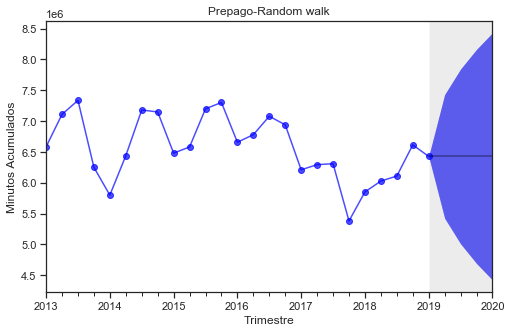

In [37]:
puntos_pred_pos = (intv_pos[0]+intv_pos[1])/2
fig, ax = fanchart(y_pos['2013':], puntos_pred_pos, intv_pos, intv_pos, intv_pos,'orange')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
plt.ylabel('Minutos Acumulados')
plt.xlabel('Trimestre')
plt.title('Postpago- Random Walk')
puntos_pred_pre = (intv_pre[0]+intv_pre[1])/2
ax.ticklabel_format(style='sci',axis='y')
fig, ax = fanchart(y_pre['2013':],puntos_pred_pre, intv_pre, intv_pre, intv_pre, 'blue')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
plt.ylabel('Minutos Acumulados')
plt.xlabel('Trimestre')
plt.title('Prepago-Random walk')

plt.show()

## Simple exponential smoothing

In [38]:
#Defino el modelo
model_pos = sm.tsa.SimpleExpSmoothing(y_pos).fit()
fitted_pos = model_pos.fittedvalues
model_pos.summary()

In [39]:
#Veamos el error MSE (pospago)
mse_pos = sm.tools.eval_measures.mse(y_pos,fitted_pos)

print(' In-sample fit:')
print(' Postpago MSE            {0:.3f}'.format(mse_pos))


 In-sample fit:
 Postpago MSE            1135737492665.678


In [40]:
N = len(y_pos)
loglik_pos=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_pos)
aic_pos = -2*loglik_pos+2*3
bic_pos = -2*loglik_pos+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_pos))
print(' AIC               {0:.3f}'.format(aic_pos))
print(' BIC               {0:.3f}'.format(bic_pos))

 Log-likelihood    -382.452
 AIC               770.905
 BIC               774.561


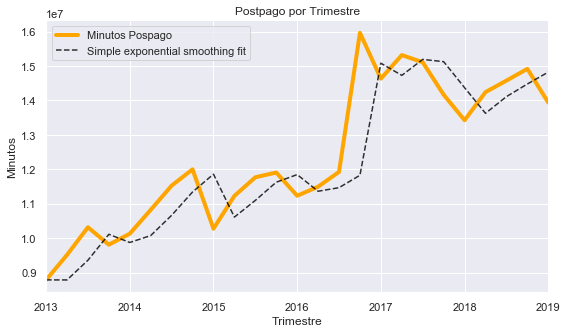

In [41]:
#Graficamos medicion y ajuste
fig, ax= plt.subplots()
y_pos.plot(color="orange", label="Minutos Pospago", lw=4)
fitted_pos.plot(color="black", label="Simple exponential smoothing fit", alpha=0.8,ls="--")
ax.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))
ax.set_xlabel("Trimestre")
ax.set_ylabel("Minutos")
ax.set_title("Postpago por Trimestre")
ax.set_xticks([], minor=True) 
plt.legend(loc="best")
sns.despine()
plt.show()

In [42]:
#Simple Smoothing para prepago
model_pre = sm.tsa.SimpleExpSmoothing(y_pre).fit()
fitted_pre = model_pre.fittedvalues
model_pre.summary()

In [43]:
mse_pre = sm.tools.eval_measures.mse(y_pre,fitted_pre)
print(' In-sample fit:')
print(' Prepago MSE               {0:.3f}'.format(mse_pre))

 In-sample fit:
 Prepago MSE               233204083017.951


In [44]:
N = len(y_pre)
loglik_pre=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_pre)
aic_pre = -2*loglik_pre+2*3
bic_pre = -2*loglik_pre+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_pre))
print(' AIC               {0:.3f}'.format(aic_pre))
print(' BIC               {0:.3f}'.format(bic_pre))

 Log-likelihood    -362.663
 AIC               731.326
 BIC               734.983


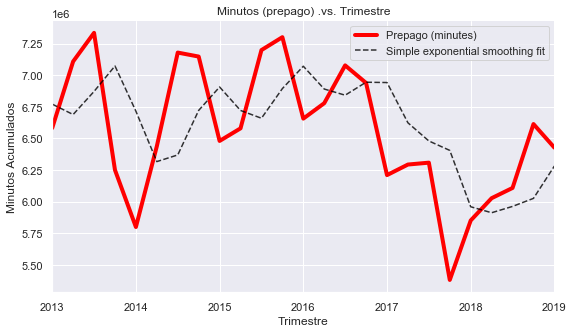

In [45]:
#Graficas de prediccion 
fig, ax= plt.subplots()
y_pre.plot(color="red", label="Prepago (minutes)", lw=4)
fitted_pre.plot(color="black", label="Simple exponential smoothing fit", alpha=0.8,ls="--")
ax.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))
ax.set_xlabel("Trimestre")
ax.set_ylabel("Minutos Acumulados")
ax.set_title("Minutos (prepago) .vs. Trimestre")
ax.set_xticks([], minor=True) 
plt.legend(loc="best")
sns.despine()
plt.show()

## Residuos

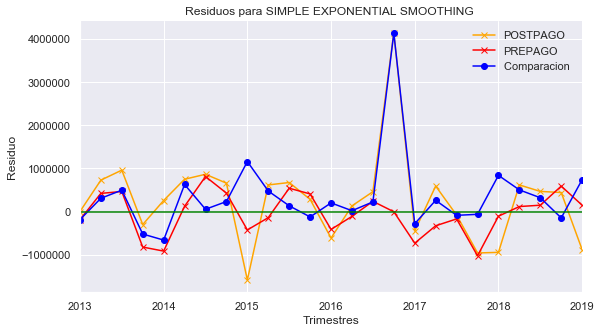

In [46]:
#Hint: Residuos (en test) = medido - ajustado

residuo_pos= y_pos - fitted_pos
residuo_pre= y_pre - fitted_pre
#quiero ver que residuo es menor
neto= abs(y_pos - fitted_pos) - abs(y_pre - fitted_pre)
fig, ax= plt.subplots(); figsize=(12,4)
residuo_pos.plot(color='orange', marker='x', label='POSTPAGO')
residuo_pre.plot(color='red', marker='x', label='PREPAGO')
neto.plot(color='blue', marker='o', label='Comparacion ')
plt.axhline(0, color='green')
ax.set_xlabel('Trimestres')
ax.set_ylabel('Residuo')
ax.set_xticks([], minor=True) 
ax.set_title("Residuos para SIMPLE EXPONENTIAL SMOOTHING " )
plt.legend(frameon=False)
sns.despine()
plt.show()


#### Observacion:  El modelo, a grandes rasgos, ajusta mejor el consumo de prepago. Pues comparacion=residuo pospago-residuo prepago; y la grafica queda sobre el eje y=0 en la mayor parte del espacio muestral. 

## Validacion :

In [47]:
(y_pre.index.get_loc('2017Q1')-1)/len(y_pre)

0.6

In [48]:
# Real time forecasting - use it as a template - expanding window

validation=y_pre['2017Q1':].index # the validation period is Q1 2017 onwards
start = y_pre.index.get_loc('2017Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y_pre)):
    
    actual.append(y_pre.iloc[i]) # actual value
    
    pred1.append(y_pre.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y_pre.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

C:\Users\gasto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a PeriodIndex by passing range endpoints is deprecated.  Use `pandas.period_range` instead.
  freq=base_index.freq)


,RW,SES,Actual
trimestre,,,
2018Q1,5380710.0,6.652596e+06,5850985.0
2018Q2,5850985.0,5.888638e+06,6027374.0
2018Q3,6027374.0,5.961212e+06,6108477.0
2018Q4,6108477.0,6.026978e+06,6613685.0
2019Q1,6613685.0,6.265001e+06,6427084.0


### Se puede apreciar que Exponential smoothing resultla ser un metodo mas preciso.

## Rolling & Expanding windows

C:\Users\gasto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a PeriodIndex by passing range endpoints is deprecated.  Use `pandas.period_range` instead.
  freq=base_index.freq)
C:\Users\gasto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a PeriodIndex by passing range endpoints is deprecated.  Use `pandas.period_range` instead.
  freq=base_index.freq)


Text(0.5, 1.0, 'Expanding & rolling - Prepago')

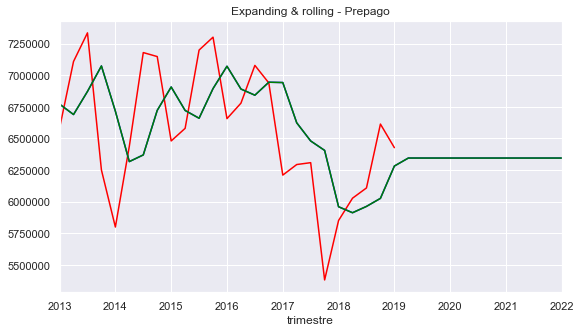

In [49]:
h=12
w=h*10
data = y_pre
model = sm.tsa.SimpleExpSmoothing
pred_index = y_pre.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');
plt.title("Expanding & rolling - Prepago")

C:\Users\gasto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a PeriodIndex by passing range endpoints is deprecated.  Use `pandas.period_range` instead.
  freq=base_index.freq)
C:\Users\gasto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a PeriodIndex by passing range endpoints is deprecated.  Use `pandas.period_range` instead.
  freq=base_index.freq)


Text(0.5, 1.0, ' Expanding & Rolling - Pospago')

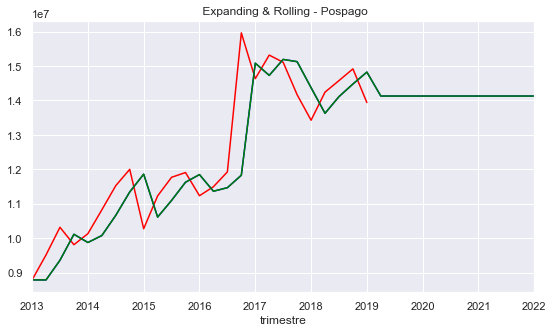

In [50]:
h=12
w=h*10
data = y_pos
model = sm.tsa.SimpleExpSmoothing
pred_index = y_pos.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='red')
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');
plt.title(" Expanding & Rolling - Pospago")